In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np 
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import models,datasets
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
from torch.optim import lr_scheduler

In [2]:

USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

device = torch.device("cuda:0" if USE_GPU else "cpu")

using device: cuda


In [3]:
#Hyperparamters
BATCH_SIZE = 64

In [4]:
train_transform = transforms.Compose([
        transforms.Resize((64,64)),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

test_transform = transforms.Compose([
        transforms.Resize((64,64)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

In [5]:
class Faces(Dataset):
    def __init__(self, filelist,directory,transform = None):
        self.filelist = filelist
        self.directory = directory
        self.transform = transform
        
    def __len__(self):
        return len(self.filelist)
    
    def __getitem__(self,idx):
        img =  Image.open(os.path.join(self.directory, self.filelist[idx]))
        img = img.convert('RGB')
        img = self.transform(img)
        
        return img
        

In [6]:
train_dir = "../input/celeba-dataset/img_align_celeba/img_align_celeba"
filelist = os.listdir(train_dir)
train_ds = Faces(filelist, train_dir, train_transform)
print(len(train_ds))
train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

202599


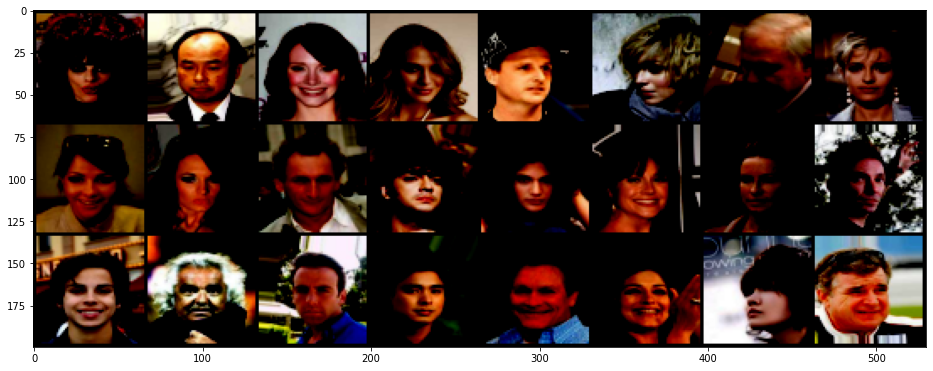

In [7]:
import matplotlib.pyplot as plt
import numpy
samples = iter(train_loader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

In [12]:
class Generator(nn.Module):
    def __init__(self,z_dim,image_dim):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(z_dim,image_dim*8,4,1,0)
        self.deconv1_bn = nn.BatchNorm2d(image_dim*8)
        self.deconv2 = nn.ConvTranspose2d(image_dim*8,image_dim*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(image_dim*4)
        self.deconv3 = nn.ConvTranspose2d(image_dim*4,image_dim*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(image_dim*2)
        self.deconv4 = nn.ConvTranspose2d(image_dim*2,image_dim, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(image_dim)
        self.deconv5 = nn.ConvTranspose2d(image_dim, 3, 4, 2, 1)

    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.leaky_relu(self.deconv1_bn(self.deconv1(input)), 0.2)
        x = F.leaky_relu(self.deconv2_bn(self.deconv2(x)), 0.2)
        x = F.leaky_relu(self.deconv3_bn(self.deconv3(x)), 0.2)
        x = F.leaky_relu(self.deconv4_bn(self.deconv4(x)), 0.2)
        x = torch.tanh(self.deconv5(x))

        return x

In [13]:
class Classif(nn.Module):
    def __init__(self, im_chan=3, hidden_dim=64,n_classes=40):
        super(Classif, self).__init__()
        self.classif = nn.Sequential(
            self.make_classif_block(im_chan, hidden_dim),
            self.make_classif_block(hidden_dim, hidden_dim * 2),
            self.make_classif_block(hidden_dim * 2, hidden_dim * 4, stride=3),
            self.make_classif_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classif_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )

    def forward(self, image):
        classif_pred = self.classif(image)
        return classif_pred.view(len(classif_pred), -1)

In [15]:
#Define loss functions
lr = 2e-4
NUM_EPOCHS = 15
z_dim = 128
image_dim = 64

#d_false = g(noise)
#d_true = next(iter(train_loader))
#gen_loss = np.log(1 - d_false)
#disc_loss = np.log(d_true)+np.log(1-d_false)

#d = Discriminator(image_dim)
#d = d.to(device)

g = Generator(z_dim,image_dim)
g = g.to(device)
criterion = nn.BCELoss()
#gen_opt = optim.Adam(g.parameters(), lr = lr)
#disc_opt = optim.SGD(d.parameters(), lr = lr)
real_label = 0
fake_label = 1

In [32]:
gen = Generator(z_dim,image_dim).to(device)
#gen = nn.DataParallel(gen)
gen.load_state_dict(torch.load('../input/celeb-a-pretrained-dataset/Faces_SNGAN_Generator.pt'))
#gen.load_state_dict(gen_dict)
gen.eval()

n_classes = 40
classifier = Classif(n_classes=40).to(device)
classifier = torch.load('../input/celeb-a-pretrained-dataset/classif.pt')
classifier.to(device)
#classifier.load_state_dict(class_dict)
classifier.eval()
print("Loaded the models!")

opt = torch.optim.Adam(classifier.parameters(), lr=0.01)
classifier

Loaded the models!


Classif(
  (classif): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(3, 3))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 40, kernel_size=(4, 4), stride=(2, 2))
      (1): Tanh()
    )
  )
)

In [21]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim,1,1, device=device)

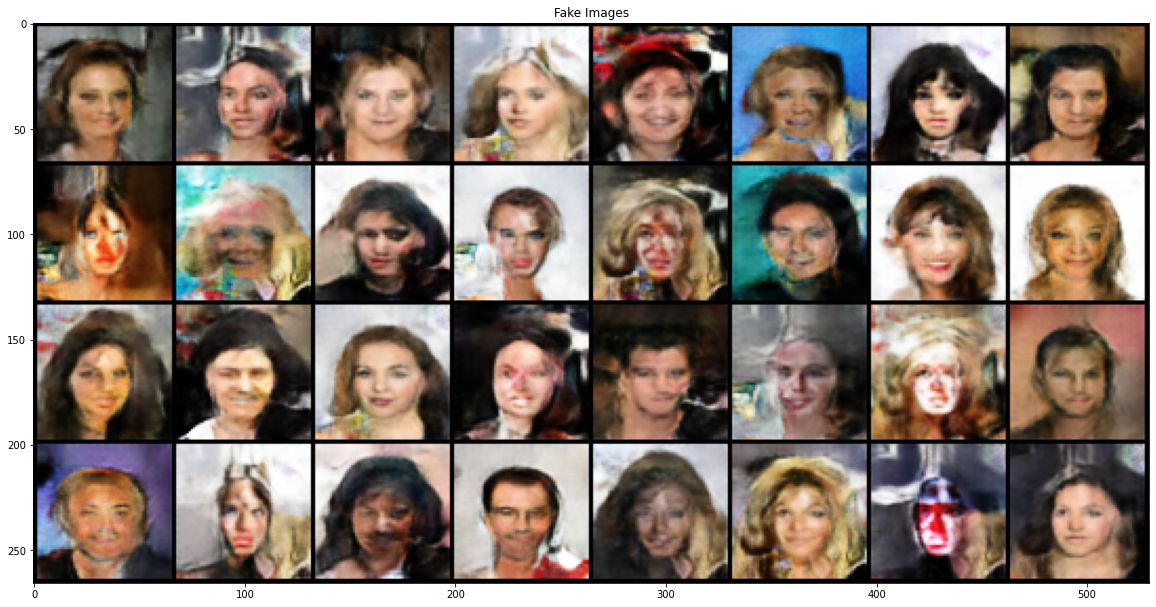

In [22]:
    n = torch.randn(BATCH_SIZE, z_dim, 1, 1).to(device)
    f = gen(n).cpu().detach()
    with torch.no_grad():
        plt.figure(figsize=(20,30))
        plt.title("Fake Images")
        img_grid = torchvision.utils.make_grid(f[0:32],normalize = True)
        plt.imshow(np.transpose(img_grid,(1,2,0)))

In [23]:
def calculate_updated_noise(noise, weight):
    #### START CODE HERE ####
  
    new_noise = noise + (noise.grad)*weight
    #### END CODE HERE ####
    return new_noise

In [24]:
def get_score(current_classifications, original_classifications, target_indices, other_indices, penalty_weight):
   
    # Calculate the norm (magnitude) of changes per example and multiply by penalty weight
    other_class_penalty = -penalty_weight*(torch.norm(current_classifications[:,other_indices] - original_classifications[:,other_indices], dim = 1).mean())
    # Take the mean of the current classifications for the target feature
    target_score = (current_classifications[:, target_indices]).mean()
    #### END CODE HERE ####
    return target_score + other_class_penalty

In [25]:
def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = torchvision.utils.make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

torch.Size([8, 3, 64, 64])


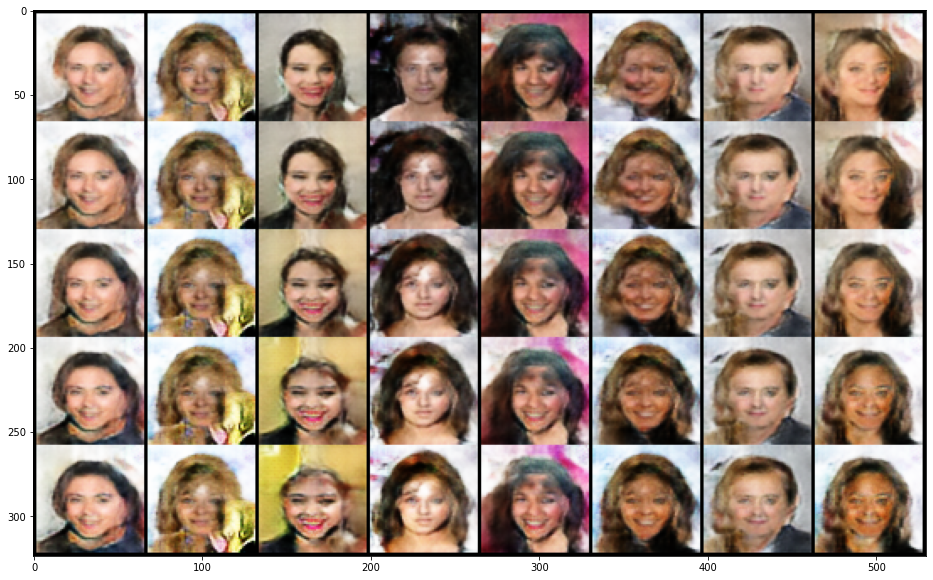

In [104]:
# First generate a bunch of images with the generator
n_images = 8
fake_image_history = []
grad_steps = 10 # Number of gradient steps to take
skip = 2 # Number of gradient steps to skip in the visualization

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]


target_indices = feature_names.index("Smiling") # Feel free to change this value to any string from feature_names from earlier!
other_indices = [cur_idx != target_indices for cur_idx, _ in enumerate(feature_names)]
noise = get_noise(n_images, z_dim).to(device).requires_grad_()
original_classifications = classifier(gen(noise)).detach()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_score = get_score(
        classifier(fake), 
        original_classifications,
        target_indices,
        other_indices,
        penalty_weight=0.1
    )
    fake_score.backward()
    noise.data = calculate_updated_noise(noise, grad_steps**(2/3))
print(fake.shape)
plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)


torch.Size([8, 3, 64, 64])


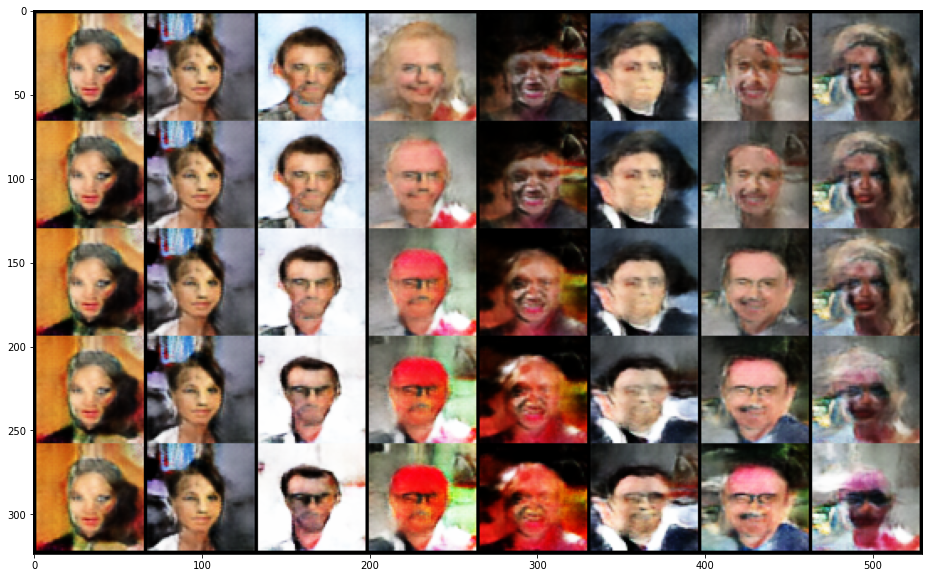

In [96]:
# First generate a bunch of images with the generator
n_images = 8
fake_image_history = []
grad_steps = 10 # Number of gradient steps to take
skip = 2 # Number of gradient steps to skip in the visualization

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]


target_indices = feature_names.index("Eyeglasses") # Feel free to change this value to any string from feature_names from earlier!
other_indices = [cur_idx != target_indices for cur_idx, _ in enumerate(feature_names)]
noise = get_noise(n_images, z_dim).to(device).requires_grad_()
original_classifications = classifier(gen(noise)).detach()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_score = get_score(
        classifier(fake), 
        original_classifications,
        target_indices,
        other_indices,
        penalty_weight=0.1
    )
    fake_score.backward()
    noise.data = calculate_updated_noise(noise, grad_steps**(2/3))
print(fake.shape)
plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)

torch.Size([8, 3, 64, 64])


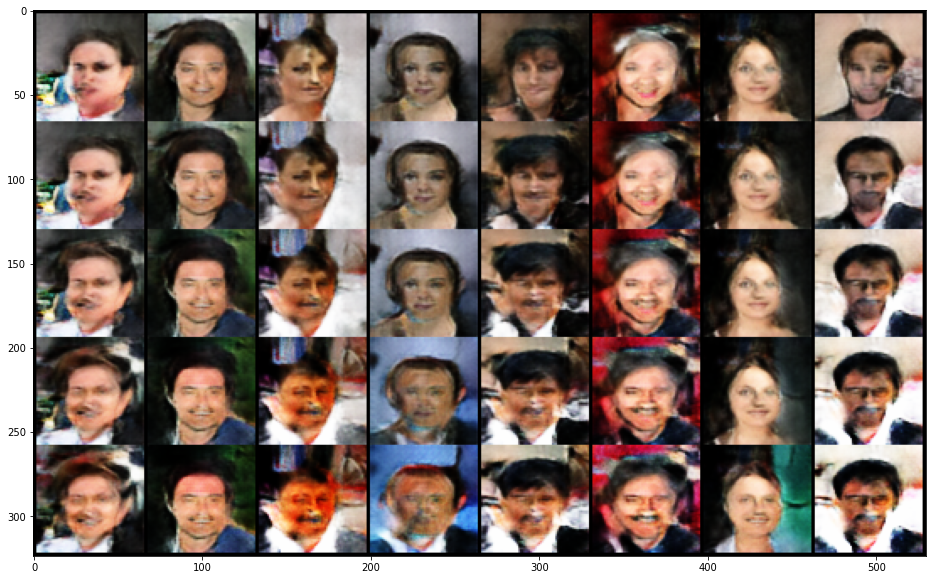

In [102]:
# First generate a bunch of images with the generator
n_images = 8
fake_image_history = []
grad_steps = 10 # Number of gradient steps to take
skip = 2 # Number of gradient steps to skip in the visualization

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]


target_indices = feature_names.index("Male") # Feel free to change this value to any string from feature_names from earlier!
other_indices = [cur_idx != target_indices for cur_idx, _ in enumerate(feature_names)]
noise = get_noise(n_images, z_dim).to(device).requires_grad_()
original_classifications = classifier(gen(noise)).detach()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_score = get_score(
        classifier(fake), 
        original_classifications,
        target_indices,
        other_indices,
        penalty_weight=0.1
    )
    fake_score.backward()
    noise.data = calculate_updated_noise(noise, grad_steps**(2/3))
print(fake.shape)
plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)

In [108]:
# First generate a bunch of images with the generator
n_images = 8
fake_image_history = []
grad_steps = 10 # Number of gradient steps to take
skip = 2 # Number of gradient steps to skip in the visualization

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]


target_indices = feature_names.index("BlondHair") # Feel free to change this value to any string from feature_names from earlier!
other_indices = [cur_idx != target_indices for cur_idx, _ in enumerate(feature_names)]
noise = get_noise(n_images, z_dim).to(device).requires_grad_()
original_classifications = classifier(gen(noise)).detach()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_score = get_score(
        classifier(fake), 
        original_classifications,
        target_indices,
        other_indices,
        penalty_weight=0.1
    )
    fake_score.backward()
    noise.data = calculate_updated_noise(noise, grad_steps**(2/3))
print(fake.shape)
plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)

torch.Size([8, 3, 64, 64])
